# **Few-Shots Learning with Prototypical Networks**

## Apprentissage profond et traitement du signal - MVA 

### Auteurs: Naïl Khelifa et Quentin Moayedpour

#### Chargement des librairies

In [1]:
## classique 

import numpy as np
import torch 
import h5py # pour gérer les formats de données utilisés ici 
import torch
from collections import Counter
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

## handmade
import src.train as train
import src.test_model as test
from src.proto_encoder import PrototypeEncoder
from src.viz import viz_tsne, plot_from_list_acc
from src.test_model import eval_n_shot

## 1. **Few Shot Learning**



Le **Few-Shot Learning (FSL)** est une technique de machine learning permettant à un modèle d'apprendre à partir de très peu d'exemples annotés. Contrairement aux méthodes traditionnelles, qui nécessitent de grandes quantités de données, le FSL cherche à reproduire la capacité humaine à généraliser rapidement à partir de quelques exemples seulement.

Formellement:

Etant donné un petit ensemble de support composé de $ N $ exemples étiquetés $ S = \{(x_1, y_1), \dots, (x_N, y_N)\} $, où chaque $ x_i \in \mathbb{R}^D $ est le vecteur de caractéristiques de dimension $ D $ d'un exemple et $ y_i \in \{1, \dots, K\} $ est le label correspondant. $ S_k $ désigne l'ensemble des exemples de label $ k $, on cherche à déduire un classificateur $f : \mathbb{R}^D \rightarrow {1, \cdots K}$ à partir de $(x_{1, k}, k), \cdots (x_{N,k}, k)$ avec $k=1, \cdots K$



### Approches Principales
1. Entraîner un modèle à apprendre à apprendre.
2. Comparer de nouveaux exemples avec ceux appris.
3. Utiliser des modèles pré-entraînés sur des grandes bases de données. (Très utilisé en CV en prenant un backbone type ImageNet)
4. Générer artificiellement plus d'exemples.

### Vocabulaire

* **In-sample data**: Données qui ont été vus par le modèle pendant l'entraînement. De manière plus général on appellera In-sample data les données d'une distribution qui a été vu par le modèle pendant l'entraînement (dans notre cas, les classes 0, 1, 2.. 5)
* **Out-of-sample data**: Inversement, données qui n'ont pas été vus par le modèle pendant l'entraînement (classes 6, 7.. 11 )
* **Espace Latent**: De manière générale, on désigne l'espace latent d'un modèle la representation au sein des couches intermédiaires du réseau. Dans notre cas étant donné que le modèle Prototype renvoi une représentation des données, on appelera l'output du réseau l'espace latent.

## Prototypical Networks for Few-shot Learning

J. Snell et al (2017) proposent un modèle pour le few shot learning qu'on nommera **Modèl Prototype**.

* <u>Intérêt du modèle</u>: Classifier des données complexes (Images par exemple) à partir de très peu d'exemples

* <u>Fonctionnement général</u>: Entraîner un modèle sur les données, ensuite prendre N exemples par classes sur le dataset de test, calculer les centroids des données dans l'espace latent (Prototypes) et pour chaque données de l'ensemble de test, la prédiction est la classe du prototype dont la distance entre le prototype et la représentation dans l'espace latent de la donnée est minimale.

![Texte alternatif](../fig/shematest.jpeg)

* <u> Avantages du modèle </u>: Architecture (relativement) simple, application rapide une fois le modèle entraîné
* <u> Limites </u>: Nécessite d'avoir un grand nombre de données annotées

### Prototypical Neural Network

Le modèle Prototype calculent une représentation $ c_k \in \mathbb{R}^M $, ou prototype, de chaque classe via une fonction d'encodage $ f_\phi : \mathbb{R}^D \to \mathbb{R}^M $ avec des paramètres appris $ \phi $. Chaque prototype est le vecteur moyen des points de support encodés appartenant à sa classe :

$$
c_k = \frac{1}{|S_k|} \sum_{(x_i, y_i) \in S_k} f_\phi(x_i) \tag{1}
$$

Étant donné une fonction de distance $ d : \mathbb{R}^M \times \mathbb{R}^M \to [0, +\infty) $, le modèle produit une distribution sur les classes pour un point de requête $ x $ basée sur un softmax des distances aux prototypes dans l'espace d'encodage :

$$
p_\phi(y = k \mid x) = \frac{\exp(-d(f_\phi(x), c_k))}{\sum_{k'} \exp(-d(f_\phi(x), c_{k'}))} \tag{2}
$$

L'apprentissage se fait en minimisant la log-probabilité négative :

$$
J(\phi) = -\log p_\phi(y = k \mid x)
$$

de la classe vraie $ k $ via la descente de gradient stochastique (SGD). Les épisodes d'entraînement sont formés en sélectionnant aléatoirement un sous-ensemble de classes à partir de l'ensemble d'entraînement, puis en choisissant un sous-ensemble d'exemples au sein de chaque classe pour agir comme ensemble de support et un sous-ensemble du reste pour servir de points de requête.


La minimisation de la Loss amène le modèle à **rapprocher** les points de requête de leur prototype de classe correct et à **éloigner** les points des prototypes des autres classes. En minimisant cette perte, le modèle apprend à **projeter** les points de la même classe près de leur prototype dans l'espace d'embedding, tout en **séparant** les prototypes des différentes classes. Cela permet au modèle de **discriminer** efficacement entre les classes, même avec un nombre très limité d'exemples (few-shot learning).


### Training Episodes

Le modèle utilise des training episode afin de calculer la perte du modèle. afin de préparer le modèle a effectuer la tâche de few shot efficacement

#### **Déroulement**

Un training episode est composé de trois éléments principaux :

1. **Sélection de classes** :
   - Un sous-ensemble de $ S_k $ classes est sélectionné aléatoirement parmi toutes les classes disponibles dans l'ensemble d'entraînement.

2. **Points de support (support set)** :
   - Pour chaque classe sélectionnée, choisir un nombre de points $x_k$ tel que $y_k \in S_k$. Calculer les $c_k$

3. **Points de requête (query set)** :
   - Sélectionner l'ensemble de requête dont les points sont de classes **différentes** que celles sélectionnées.

4. **Classification des points de requête** :
   - Pour chaque point de requête $ \mathbf{x} \in Q_k $, calculer la probabilité qu'il appartienne à $ k $ en      $ p_\phi(y = k | \mathbf{x})$
     où $ d $ est une fonction de distance (par exemple, la distance euclidienne).

3. **Calcul de la perte** :


     $J(\phi) = -\frac{1}{N_C \cdot N_Q} \sum_{k=1}^{N_C} \sum_{(\mathbf{x}, y) \in Q_k} \log p_\phi(y = k | \mathbf{x})$
   - Actualiser les poids du modèle.

---
 Les training episodes permettent au modèle de s'entraîner dans des conditions similaires à celles du test, où il devra généraliser à de nouvelles classes avec peu d'exemples. En s'entraînant sur des classes différentes à chaque épisode, le modèle apprend à **extraire des caractéristiques générales** qui sont utiles pour discriminer entre des classes jamais vues.
---

![img](../fig/proto2.png)

Maintenant Passons à l'implémentation !

## 1. **Entraînement de l'encodeur**

On commence par charger les données d'entraînement, que l'on va plus tard utiliser pour entraîner le modèle de few-shot learning en question. 

In [2]:
opt = {
    'train_dataset_path': '../data/train.hdf5',  # Path to the dataset
    'epochs': 2,  # Number of epochs for training
    'learning_rate': 0.001,  # Learning rate for the optimizer
    'lr_scheduler_step': 20,  # Step size for the learning rate scheduler
    'lr_scheduler_gamma': 0.5,  # Multiplicative factor for learning rate decay
    'iterations': 100,  # Number of episodes per epoch
    'classes_per_it_tr': 5,  # Number of classes per training iteration
    'num_support_tr': 20,  # Number of support samples per class for training
    'num_query_tr': 20,  # Number of query samples per class for training
    'classes_per_it_val': 5,  # Number of classes per validation iteration
    'num_support_val': 5,  # Number of support samples per class for validation
    'num_query_val': 15,  # Number of query samples per class for validation
    'manual_seed': 7,  # Manual seed for reproducibility
    'device': 'cuda:0',  # Whether to use CUDA for computation
    'p_data': 1, # % of data of the train set used for training
}

In [3]:
model, best_acc, train_loss, train_acc = train.main(opt)

=== Epoch: 0 ===


100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


Avg Train Loss: 1.1144161862134934, Avg Train Acc: 0.4219999985396862
=== Epoch: 1 ===


100%|██████████| 100/100 [00:53<00:00,  1.87it/s]

Avg Train Loss: 0.7244796922802925, Avg Train Acc: 0.6192999994754791
Final model saved to ../logs/last_model.pth


On peut s'intéresser à la représentation du modèle des données d'entraînement. On réduit la dimension de la représentation à l'aide de T-SNE et on visualise les données par classes. 

In [9]:
from src.test_model import test_n_shot
from src.viz import plot_from_list_acc

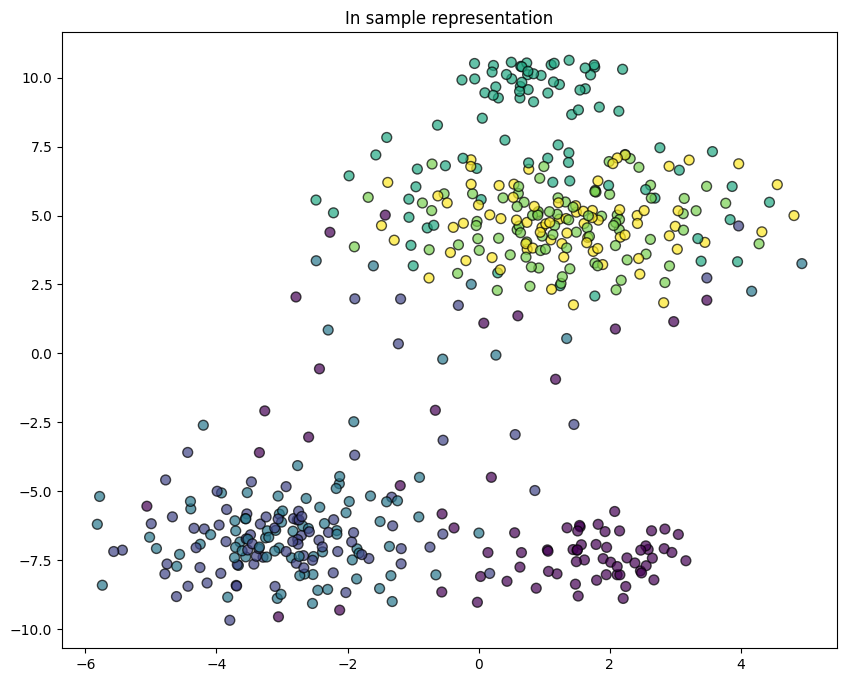

In [5]:
viz_tsne(model, task="train")

#TODO Commenter :)

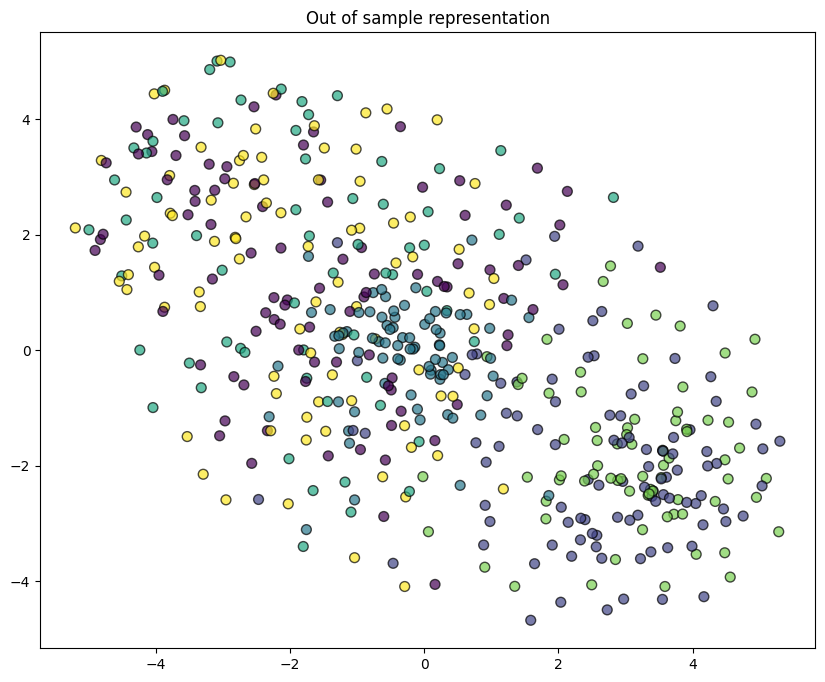

In [6]:
viz_tsne(model, task="enroll")

Proche de l'aléatoire...

In [7]:
model = PrototypeEncoder()

state_dict_path_20 = "../logs/last_model_Ns100_Nq100_cl5_ep100.pth"  # Path to the saved state_dict file

state_dict_20 = torch.load(state_dict_path_20, map_location=torch.device('cuda:0'))
model.load_state_dict(state_dict_20)
model = model.to("cuda:0")

/tmp/ipykernel_1924/1382448129.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict_20 = torch.load(state_dict_path_20, map_location=torch.device('cuda:0'))


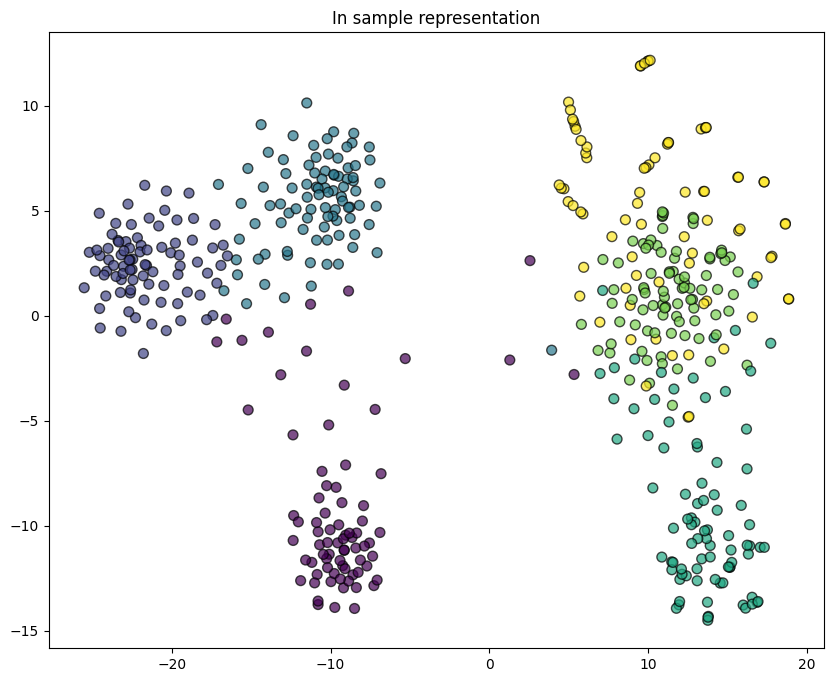

In [8]:
viz_tsne(model, task="train")

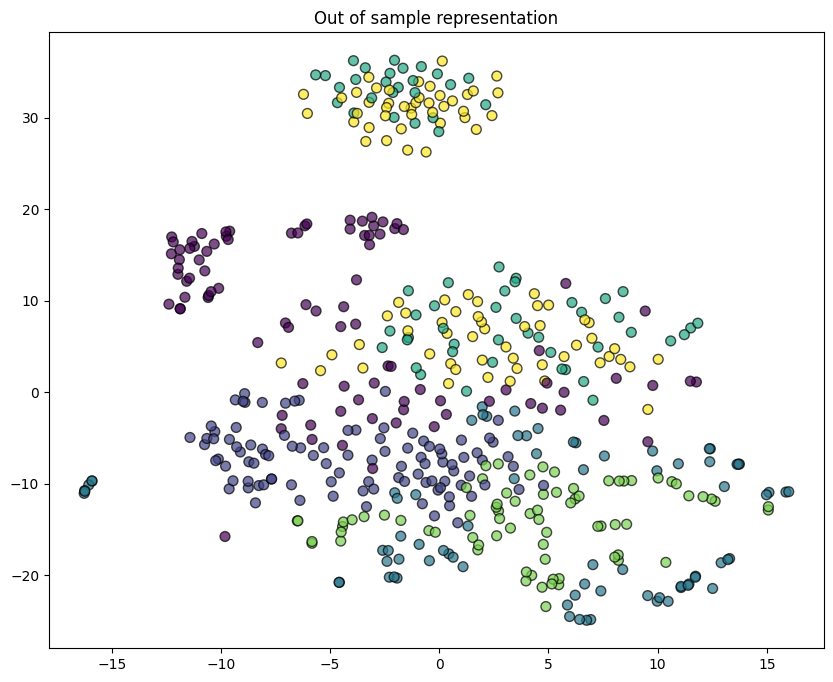

In [9]:
viz_tsne(model, task="enroll", max_x=50000)

On a $\texttt{x\_enroll.size() = torch.Size([500, 2, 2048])}$ donc on dispose de 500 échantillons pour enrôler les nouvelles classes. C'est peut-être inutilement grand. On se propose donc d'observer ce qu'il se passe si on réduit l'enrollement lors du calcul des prototypes.

## Model Not Trained

100%|██████████| 9/9 [00:36<00:00,  4.02s/it]


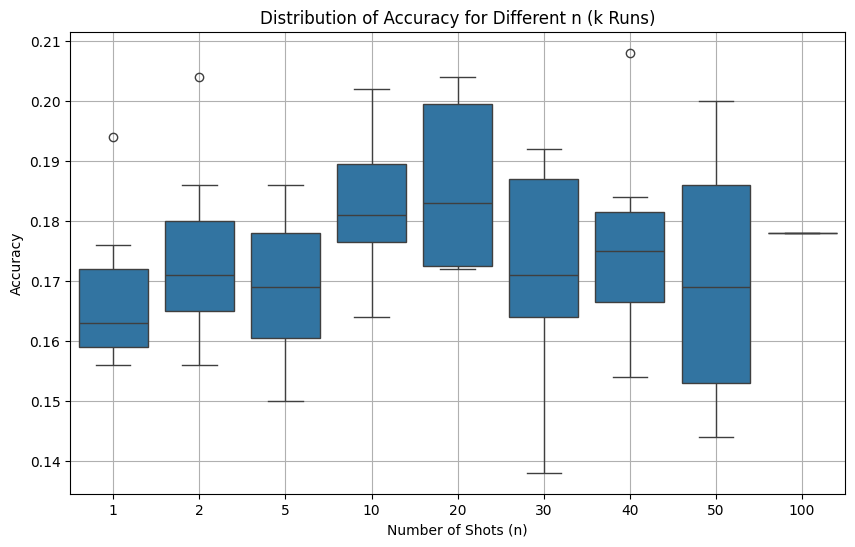

In [10]:
from src.viz import plot_from_list_acc
from src.test_model import test_n_shot

model = PrototypeEncoder()
model = model.to("cuda:0")
list_n = [1, 2, 5, 10, 20, 30, 40, 50, 100]
list_acc = eval_n_shot(model, k=10, list_n=list_n)
plot_from_list_acc(list_acc)

## Model trained on few epochs

In [11]:
model = PrototypeEncoder()

state_dict_path_20 = "./last_model.pth"  # Path to the saved state_dict file

state_dict_20 = torch.load(state_dict_path_20, map_location=torch.device('cuda:0'))
model.load_state_dict(state_dict_20)
model = model.to("cuda:0")

/tmp/ipykernel_1924/3483792568.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict_20 = torch.load(state_dict_path_20, map_location=torch.device('cuda:0'))


100%|██████████| 9/9 [00:33<00:00,  3.70s/it]


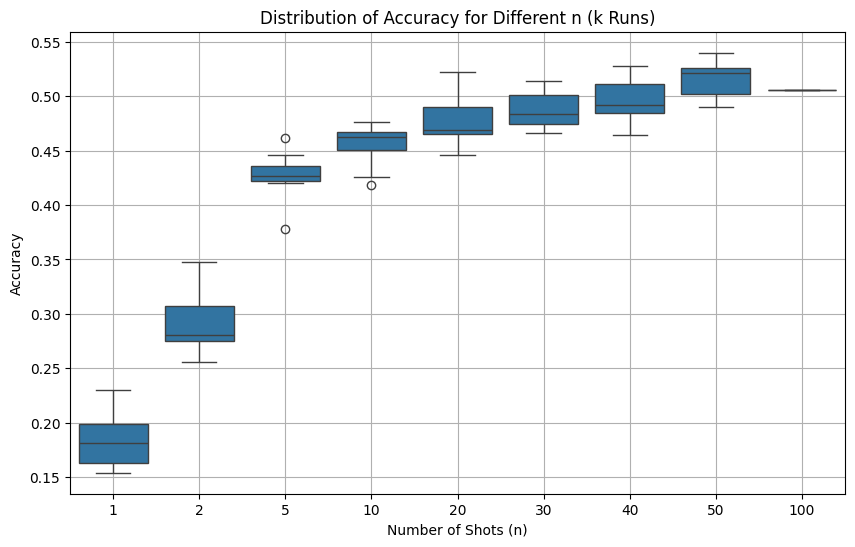

In [12]:
list_acc = eval_n_shot(model, k=10)
plot_from_list_acc(list_acc)

## Model trained on a large n of epochs

In [13]:
model = PrototypeEncoder()

state_dict_path_20 = "../logs/last_model_Ns100_Nq100_cl5_ep100.pth"  # Path to the saved state_dict file

state_dict_20 = torch.load(state_dict_path_20, map_location=torch.device('cuda:0'))
model.load_state_dict(state_dict_20)
model = model.to("cuda:0")

/tmp/ipykernel_1924/1382448129.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict_20 = torch.load(state_dict_path_20, map_location=torch.device('cuda:0'))


100%|██████████| 9/9 [00:32<00:00,  3.65s/it]


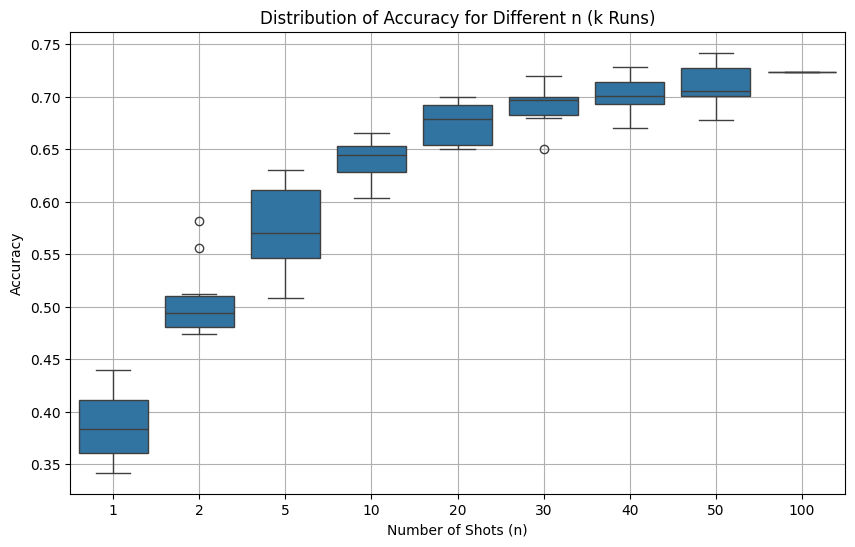

In [14]:
list_acc = eval_n_shot(model, k=10)
plot_from_list_acc(list_acc)

On voit ici que l'entraînement du modèle a un grand impact, les performances sont augmentées en utilisant un modèle qui s'est entraîné plus longtemps.

### Performances en fonction du nombres de données d'entraînement:

In [8]:
opt = {
    'train_dataset_path': '../data/train.hdf5',  # Path to the dataset
    'epochs': 5,  # Number of epochs for training
    'learning_rate': 0.001,  # Learning rate for the optimizer
    'lr_scheduler_step': 20,  # Step size for the learning rate scheduler
    'lr_scheduler_gamma': 0.5,  # Multiplicative factor for learning rate decay
    'iterations': 100,  # Number of episodes per epoch
    'classes_per_it_tr': 5,  # Number of classes per training iteration
    'num_support_tr': 20,  # Number of support samples per class for training
    'num_query_tr': 20,  # Number of query samples per class for training
    'classes_per_it_val': 5,  # Number of classes per validation iteration
    'num_support_val': 5,  # Number of support samples per class for validation
    'num_query_val': 15,  # Number of query samples per class for validation
    'manual_seed': 7,  # Manual seed for reproducibility
    'device': 'cuda:0',  # Whether to use CUDA for computation
    'p_data': 0.8, # % of data of the train set used for training
}

In [ ]:
### Ne pas faire tourner (prends du temps)
### Prendre plutot le dictionnaire results.json !!

list_p = [0.05, 0.1, 0.3, 0.5, 1]
results = {}
for p in tqdm(list_p):
    results[p] = {}
    opt["p_data"] = p

    results[p]["model"], _, results[p]["Loss"], results[p]["Accuracy"] = train.main(opt)

    results[p]["perfs"] = eval_n_shot(results[p]["model"], k=10)



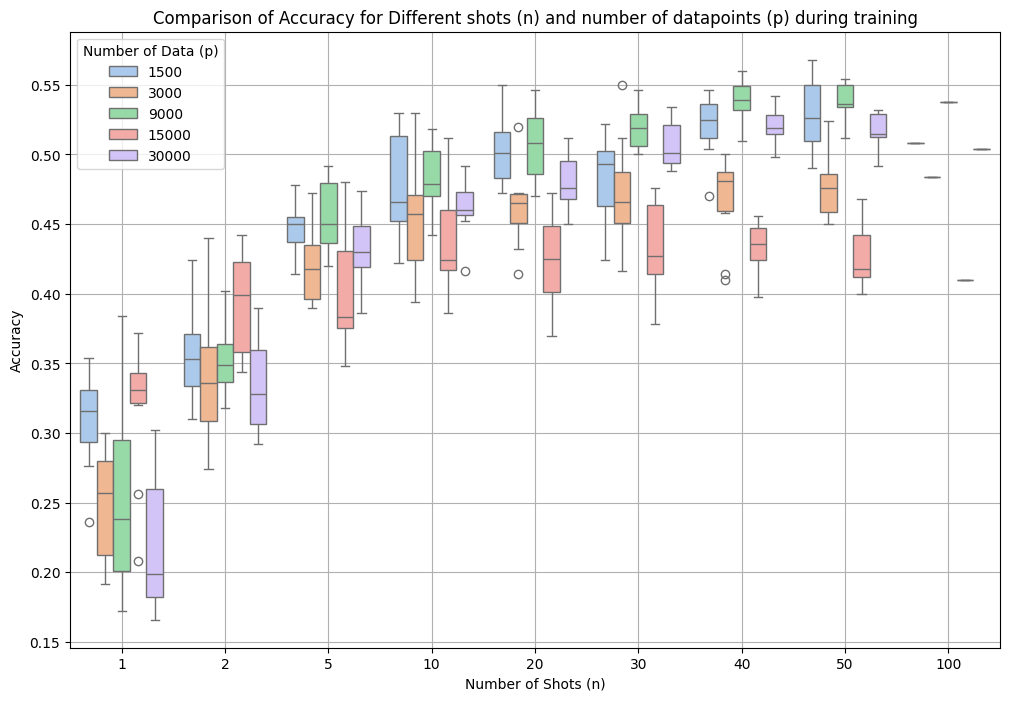

In [ ]:
def plot_from_results(results):

    acc_values = []
    n_labels = []
    p_labels = []
    
    for p, data in results.items():
        list_acc = data["perfs"]
        for n, acc_list in list_acc.items():
            acc_values.extend(acc_list)
            n_labels.extend([n] * len(acc_list))
            p_labels.extend([int(p*30000)] * len(acc_list)) # 30000 correspond a la taille du train

    plt.figure(figsize=(12, 8))
    sns.boxplot(x=n_labels, y=acc_values, hue=p_labels, palette="pastel")
    
    plt.xlabel('Number of Shots (n)')
    plt.ylabel('Accuracy')
    plt.title('Comparison of Accuracy for Different shots (n) and number of datapoints (p) during training')
    plt.legend(title="Number of Data (p)", loc="best")
    plt.grid(True)

    plt.show()

plot_from_results(results)

Nombre de données ne semble pas être un grand déterminant, on obtient des résultats similaires en utilisant 1500 signaux et 30000 signaux. Un meilleur déterminant devrait être le nombre d'itérations pendant l'entraînement.

In [28]:
opt = {
    'train_dataset_path': '../data/train.hdf5',  # Path to the dataset
    'epochs': 5,  # Number of epochs for training
    'learning_rate': 0.001,  # Learning rate for the optimizer
    'lr_scheduler_step': 20,  # Step size for the learning rate scheduler
    'lr_scheduler_gamma': 0.5,  # Multiplicative factor for learning rate decay
    'iterations': 100,  # Number of episodes per epoch
    'classes_per_it_tr': 5,  # Number of classes per training iteration
    'num_support_tr': 20,  # Number of support samples per class for training
    'num_query_tr': 20,  # Number of query samples per class for training
    'classes_per_it_val': 5,  # Number of classes per validation iteration
    'num_support_val': 5,  # Number of support samples per class for validation
    'num_query_val': 15,  # Number of query samples per class for validation
    'manual_seed': 7,  # Manual seed for reproducibility
    'device': 'cuda:0',  # Whether to use CUDA for computation
    'p_data': 0.4, # % of data of the train set used for training
}

In [ ]:
### Ici le nombre d'itération par modèle sera de n_epochs(5) * n_iters

n_iters = [10, 20, 50, 100, 200]
results = {}
for n_iter in tqdm(n_iters):
    results[n_iter] = {}
    opt["iterations"] = n_iter

    results[n_iter]["model"], _, results[n_iter]["Loss"], results[n_iter]["Accuracy"] = train.main(opt)

    results[n_iter]["perfs"] = eval_n_shot(results[n_iter]["model"], k=10)



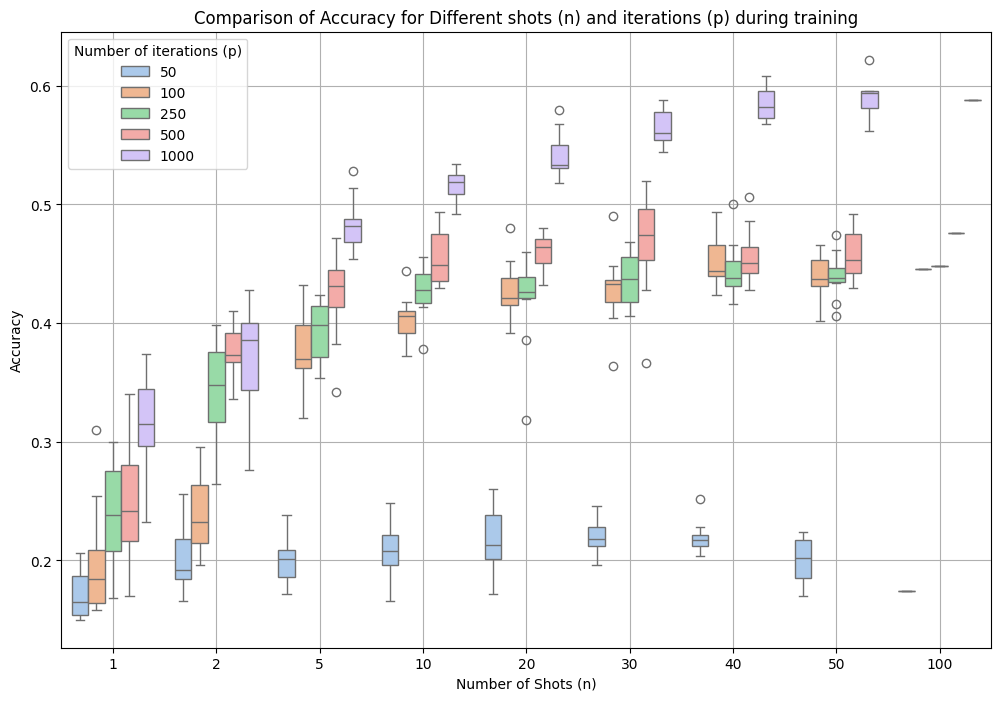

In [32]:
def plot_from_iterations(results):

    acc_values = []
    n_labels = []
    p_labels = []
    
    for p, data in results.items():
        list_acc = data["perfs"]
        for n, acc_list in list_acc.items():
            acc_values.extend(acc_list)
            n_labels.extend([n] * len(acc_list))
            p_labels.extend([int(p*5)] * len(acc_list)) # p*5 pour le nombre d'itération (5= nombre d epochs)

    plt.figure(figsize=(12, 8))
    sns.boxplot(x=n_labels, y=acc_values, hue=p_labels, palette="pastel")
    
    plt.xlabel('Number of Shots (n)')
    plt.ylabel('Accuracy')
    plt.title('Comparison of Accuracy for Different shots (n) and iterations (p) during training')
    plt.legend(title="Number of iterations (p)", loc="best")
    plt.grid(True)

    plt.show()

plot_from_iterations(results)

In [33]:
opt = {
    'train_dataset_path': '../data/train.hdf5',  # Path to the dataset
    'epochs': 5,  # Number of epochs for training
    'learning_rate': 0.001,  # Learning rate for the optimizer
    'lr_scheduler_step': 20,  # Step size for the learning rate scheduler
    'lr_scheduler_gamma': 0.5,  # Multiplicative factor for learning rate decay
    'iterations': 100,  # Number of episodes per epoch
    'classes_per_it_tr': 5,  # Number of classes per training iteration
    'num_support_tr': 20,  # Number of support samples per class for training
    'num_query_tr': 20,  # Number of query samples per class for training
    'classes_per_it_val': 5,  # Number of classes per validation iteration
    'num_support_val': 5,  # Number of support samples per class for validation
    'num_query_val': 15,  # Number of query samples per class for validation
    'manual_seed': 7,  # Manual seed for reproducibility
    'device': 'cuda:0',  # Whether to use CUDA for computation
    'p_data': 0.4, # % of data of the train set used for training
}

In [ ]:
### On met le meme nombre pour le support et le query

n_supps = [1, 2, 5, 10, 20, 50]
results = {}
for n_supp in tqdm(n_supps):
    results[n_supp] = {}
    opt["num_support_tr"] = opt["num_query_tr"] = n_supp

    results[n_supp]["model"], _, results[n_supp]["Loss"], results[n_supp]["Accuracy"] = train.main(opt)

    results[n_supp]["perfs"] = eval_n_shot(results[n_supp]["model"], k=10)



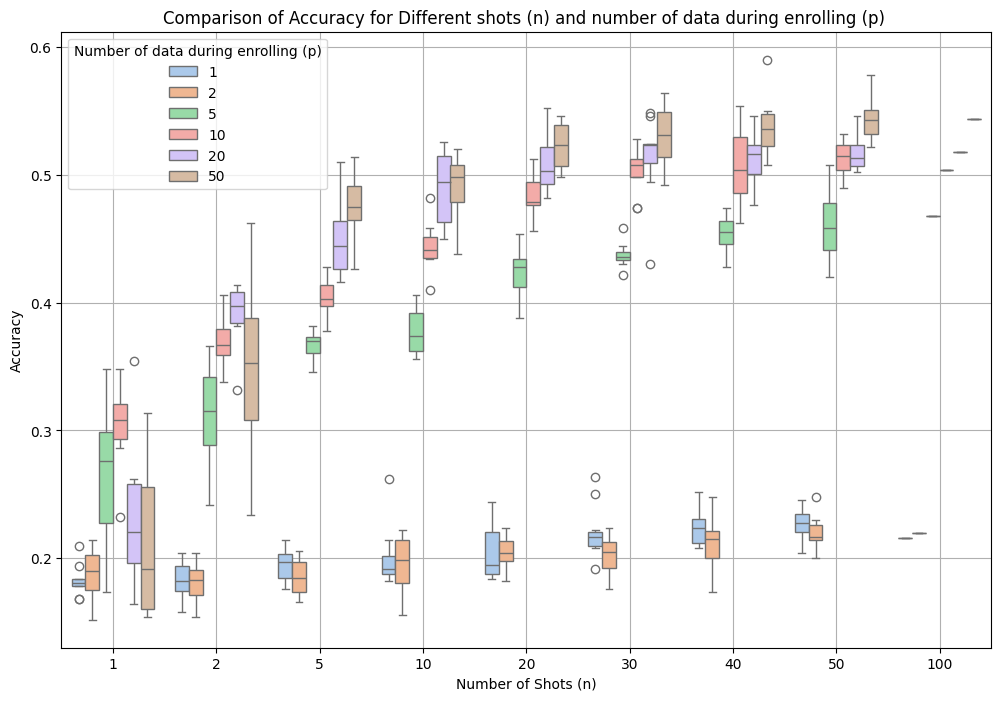

In [35]:
def plot_from_enroll(results):

    acc_values = []
    n_labels = []
    p_labels = []
    
    for p, data in results.items():
        list_acc = data["perfs"]
        for n, acc_list in list_acc.items():
            acc_values.extend(acc_list)
            n_labels.extend([n] * len(acc_list))
            p_labels.extend([int(p)] * len(acc_list)) # 

    plt.figure(figsize=(12, 8))
    sns.boxplot(x=n_labels, y=acc_values, hue=p_labels, palette="pastel")
    
    plt.xlabel('Number of Shots (n)')
    plt.ylabel('Accuracy')
    plt.title('Comparison of Accuracy for Different shots (n) and number of data during enrolling (p) ')
    plt.legend(title="Number of data during enrolling (p)", loc="best")
    plt.grid(True)

    plt.show()

plot_from_enroll(results)

On teste maintenant sur un plus gros modèle

In [3]:
model = PrototypeEncoder()

state_dict_path_20 = "../logs/last_model_Ns100_Nq100_cl5_ep100.pth"  # Path to the saved state_dict file

state_dict_20 = torch.load(state_dict_path_20, map_location=torch.device('cuda:0'))
model.load_state_dict(state_dict_20)
model = model.to("cuda:0")

/tmp/ipykernel_2116/1382448129.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict_20 = torch.load(state_dict_path_20, map_location=torch.device('cuda:0'))


In [4]:
list_res = eval_n_shot(model, k=20)

100%|██████████| 9/9 [00:51<00:00,  5.72s/it]


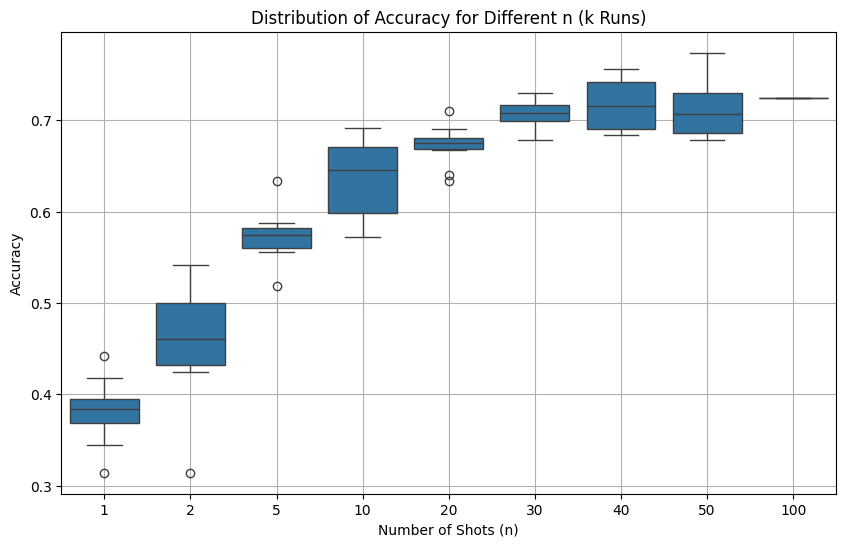

In [5]:
plot_from_list_acc(list_res)